# Purpose

The goal of this notebook is to 
1. document the process leading to the decisions made in 2023_openfield.py including using the classifiers and documenting their utility.
2. Allow for modifications in the analysis of individual files if the automatic analyses fail.

# Imports

In [1]:
import numpy as np
import pandas as pd
import glob, os, csv, cv2, math, itertools, warnings, joblib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from scipy.io import arff

In [2]:
def reformat_df(df,likelihood_val,max_px_value,frame_limit_val,seconds,fps):
    """ this function takes a dataframe containing the data from DeepLabCut 
    predictions on a video and some user inputs to remove data that doesn't meet a
    likelihood threshold (user input) and also exclude large jumps from the data, 
    based on max_px_value user input. Finally, it smooths the data using additional
    user inputs. 
    
    INPUTS:
    1. df - a pandas dataframe object
    2. likelihood_val - a float, typically .9, which is used to remove (fill with nans)
    any data which doesn't meet this criteria/confidence from DLC prediction
    3. max_px_value - an integer, that dictates how far away in pixels a point can be 
    without being discarded as an outlier (e.g. if the nose is annotated at 0,0 at time=0 and the
    max_px_value is 100, if at time=1 the value is 0,101 that value would be replaced with nan
    4. frame_limit_val - an integer that says over how many frames we interpolate between for 
    labeled animal points. e.g. if the nose was visible at frame 0 and frame 2, but had low confidence
    and was therefore removed for frame 1, the nose was likely present in frame 1, and lies somewhere
    between points 0 and 2. A frame_limit_val of 2 or more would allow this to be 'filled in' by
    interpolation. If frame_limit_val is set to 0 or 1, no interpolation occurs.
    5. seconds - an integer that says over how many seconds we take the median value for each
    data point of BOX VALUES ONLY. This is used to remove discontinuities.
    6. fps- a float representing the framerate of the video that DLC was run on, typically 29.93)
    
    OUTPUTS: a pandas dataframe object with the smoothed, high-confidence data from the DLC points
    """
    new_df=pd.DataFrame()
    cols = np.unique([col[0] for col in df.columns])
    for col in cols:
        print(col)
        if "bodyparts" not in col:
            part = df[col]
            for idx in np.arange(0,len(part.x)):
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
                second_idx = np.max([0,idx-1])
                if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                    part[idx] = np.nan
                elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                    part.x[idx] = np.nan

            if "box" not in col and "opening" not in col and "bodyparts" not in col:
                print(col)
                part.x = part.x.interpolate(limit=frame_limit_val)
                part.y = part.y.interpolate(limit=frame_limit_val)
                new_part = pd.concat({col:part},axis=1)
                if col == cols[1]:
                    new_df=new_part
                else:
                    new_df = pd.concat([new_df,new_part],axis=1)
            else:
                part.x=part.x.rolling(seconds*fps).median()
                part.x = part.x.interpolate()
                part.y=part.y.rolling(seconds*fps).median()
                part.y = part.y.interpolate()
                new_location = pd.concat({col:part},axis=1)
                new_df=pd.concat([new_df,new_location],axis=1)
            
    return new_df

In [3]:
def align_df(df):
    """this function takes the processed DLC data and puts all labeled points in "mm space", such
    that the corners of the box are at 0,0 0,500, 500,500 and 500,0.
    
    INPUTS: a data frame containing smoothed, high-confidence DLC data
    
    OUTPUTS: a pandas dataframe object, after adjusting all location points to mm space, 
    rather than pixel space
    """
    new_df=pd.DataFrame()
    # for each index, get the box coords, find transformation matrix, then apply it to all other points
    s1=[0,500]
    s2=[500,500]
    s3=[0,0]
    s4=[500,0]
    for idx in np.arange(0,len(df)):
        if idx%1000==0:
            print('at {} of {} rows'.format(idx,len(df)))
        # get box points
        p1=[df.box_bl.x[idx],df.box_bl.y[idx]] #0,500
        p2=[df.box_br.x[idx],df.box_br.y[idx]] #500,500
        p3=[df.box_tl.x[idx],df.box_tl.y[idx]] #0,0
        p4=[df.box_tr.x[idx],df.box_tr.y[idx]] #500,0
        # get transform matrix
        M = cv2.getPerspectiveTransform(np.float32([p1,p2,p3,p4]),np.float32([s1,s2,s3,s4]))
        # apply transform matrix to other points
        sub_df=df[df.index==idx].copy()
        for i in np.arange(0,len(sub_df.columns),3):
            p1_0=sub_df.iloc[0,i]
            p1_1=sub_df.iloc[0,i+1]
            if np.isnan(p1_0):
                p1_0_new=np.nan
                p1_1_new=np.nan
            else:
                # set points
                pts = np.array([[[p1_0,p1_1]]],dtype='float32')
                # use transform matrix to un-warp the points
                [p1_0_new,p1_1_new]=cv2.perspectiveTransform(pts,M)[0][0]
            sub_df.iloc[0,i]=p1_0_new
            sub_df.iloc[0,i+1]=p1_1_new
        new_df=pd.concat([new_df,sub_df],axis=0)
    return new_df

# User inputs

In [4]:
FPS=29.93 #frames per second of the video, typically 29.93
#filename='../data/' # full path to the DLC file you'd like to work on
# TODO change to include an example in file structure
filename = '../../../alex_revised/VID_20220731_102540DLC_resnet50_2022_Knowles_AlexOct13shuffle1_250000.csv'
# V
#  
trained_file = '../data/20230305_RF_jumps_rears.pkl'

# Procedure for working with a particular file

In [5]:
sub_file_name=filename.split('/')[-1][0:19]
print(sub_file_name) #this is the subfilename

VID_20220731_102540


In [6]:
# read in the file and look at it
df = pd.read_csv(filename,header=[1,2])
df

bodyparts     box_tl                             box_tr              \
         coords          x           y likelihood           x           y   
0             0  93.592545  763.601379   0.739556  991.507263  760.003479   
1             1  93.581177  763.595581   0.724415  991.518066  760.042297   
2             2  93.046150  763.501831   0.718300  991.518738  759.959290   
3             3  91.622559  763.495361   0.721888  990.488586  760.220459   
4             4  92.101685  763.141907   0.615689  990.315857  759.876343   
...         ...        ...         ...        ...         ...         ...   
28955     28955  89.663551  755.945984   0.842185  995.975159  754.743774   
28956     28956  90.804642  757.714905   0.830615  996.230591  754.991821   
28957     28957  88.592453  757.007996   0.693517  995.044495  755.282288   
28958     28958  88.586082  757.758789   0.661655  994.648376  755.018127   
28959     28959  89.985497  760.134216   0.814107  995.054688  755.898987   

                     box_bl                          ... paw_left_front  \
      likelihood          x            y likelihood  ...     likelihood   
0       0.565929  89.771881  1661.583252   0.917342  ...       0.034472   
1       0.567074  89.702927  1661.554810   0.917190  ...       0.034305   
2       0.544464  88.511818  1662.262207   0.935872  ...       0.036274   
3       0.606323  87.896568  1662.709351   0.949122  ...       0.035237   
4       0.634390  87.795410  1662.316040   0.958582  ...       0.038511   
...          ...        ...          ...        ...  ...            ...   
28955   0.964723  85.187233  1663.407715   0.958823  ...       0.033998   
28956   0.972929  85.999611  1663.364868   0.952378  ...       0.030887   
28957   0.979511  84.297935  1664.553345   0.948562  ...       0.037443   
28958   0.981510  84.747566  1665.410889   0.970451  ...       0.037398   
28959   0.972707  85.660934  1666.212280   0.943505  ...       0.043516   

      paw_right_front                        paw_left_back              \
                    x           y likelihood             x           y   
0          595.415161  754.096008   0.035374    600.221985  754.143005   
1          595.383972  754.121521   0.035114    600.195007  754.176941   
2          595.306946  754.408203   0.037399    599.968445  754.583191   
3          594.673096  754.830017   0.037762    599.118347  755.177734   
4          594.844055  754.516113   0.041372    599.080200  754.890808   
...               ...         ...        ...           ...         ...   
28955      596.912842  750.479065   0.054711    604.335022  750.226868   
28956      597.544678  750.721069   0.049113    604.921692  750.793396   
28957      595.796387  750.757507   0.058031    599.175171  748.135742   
28958      595.299011  750.900391   0.056786    602.719910  750.618774   
28959      595.531372  754.022034   0.072319    604.187683  751.707214   

                 paw_right_back                         
      likelihood              x           y likelihood  
0       0.041230     595.286438  756.806213   0.037682  
1       0.041046     595.230103  756.833679   0.037179  
2       0.044734     595.022278  757.277222   0.040701  
3       0.048096     594.272522  757.725830   0.041995  
4       0.054522     594.138123  757.721375   0.052698  
...          ...            ...         ...        ...  
28955   0.051475     597.918945  755.476685   0.067631  
28956   0.053600     598.482788  755.330505   0.054701  
28957   0.041684     597.601807  755.337341   0.074272  
28958   0.047239     596.755554  756.389771   0.075398  
28959   0.054729     598.062927  757.275085   0.077986  

[28960 rows x 46 columns]

In [7]:
plt.scatter(df.box_tr["x"][a:b],df.box_tr["y"][a:b],c='c',alpha=0.02,s=100)



NameError: name 'a' is not defined

In [ ]:
# let's look at the points annotated by DLC

# this plots all frames, from the first (0) to the last (-1), 
# if you want to plot a subset of frames, change a and b values

a=5000
b=8000
plt.figure(figsize=(10,10))
plt.scatter(df.box_tl["x"][a:b],df.box_tl["y"][a:b],c='b',alpha=0.02,s=100)
plt.scatter(df.box_tr["x"][a:b],df.box_tr["y"][a:b],c='c',alpha=0.02,s=100)
plt.scatter(df.box_bl["x"][a:b],df.box_bl["y"][a:b],c='g',alpha=0.02,s=100)
plt.scatter(df.box_br["x"][a:b],df.box_br["y"][a:b],c='k',alpha=0.02,s=100)
plt.scatter(df.opening_bottom["x"][a:b],df.opening_bottom["y"][a:b],c='r',alpha=0.02)
plt.scatter(df.opening_top["x"][a:b],df.opening_top["y"][a:b],c='pink',alpha=0.02)
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title('box corners as identified by DLC in black, cyan, blue, and green \n opening to the box in pink and red')
plt.show()

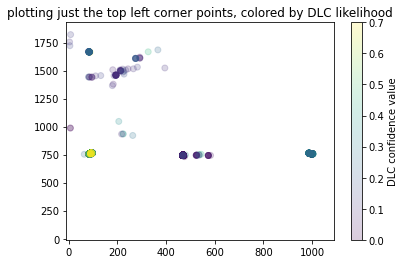

In [8]:
""" adjust your likelihood_max based on this and the following plot's data. 
you can change what you plot by as well for example, df.box_tl could be 
any column in df (box_tr, opening_top, etc.) If a particular point is not aligning or looks 'wrong'
this is a good place to test out how to change it
"""
plt.scatter(df.box_tl["x"],df.box_tl["y"],c=df.box_tl['likelihood'],alpha=0.2)
plt.clim(0,.7)
plt.xlim(-10,1090)
plt.ylim(-10,1930)
cbar=plt.colorbar()
cbar.set_label('DLC confidence value')
plt.title('plotting just the top left corner points, colored by DLC likelihood')
plt.show()

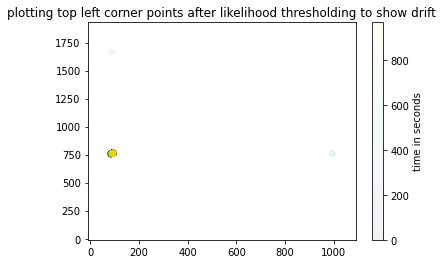

In [9]:
likelihood_max=0.72
subset_vector=df.box_tl.likelihood>likelihood_max

plt.scatter(df.box_tl["x"][subset_vector],df.box_tl["y"][subset_vector],c=df.index[subset_vector]/FPS,alpha=0.05)
plt.xlim(-10,1090)
plt.ylim(-10,1930)
cbar=plt.colorbar()
cbar.set_label('time in seconds')
plt.title('plotting top left corner points after likelihood thresholding to show drift')
plt.show()

from this, we see that a likelihood_max value of 0.9 is removing obviously wrong values, while allowing the camera drift to still be captured

In [11]:
# let's get some data to plot from the dataframe, a warning may appear, you can ignore it
s = df.box_br["y"].copy()
for idx in np.arange(0,len(s)):
    if df.box_tl.likelihood[idx]<likelihood_max:
        s[idx]=np.nan

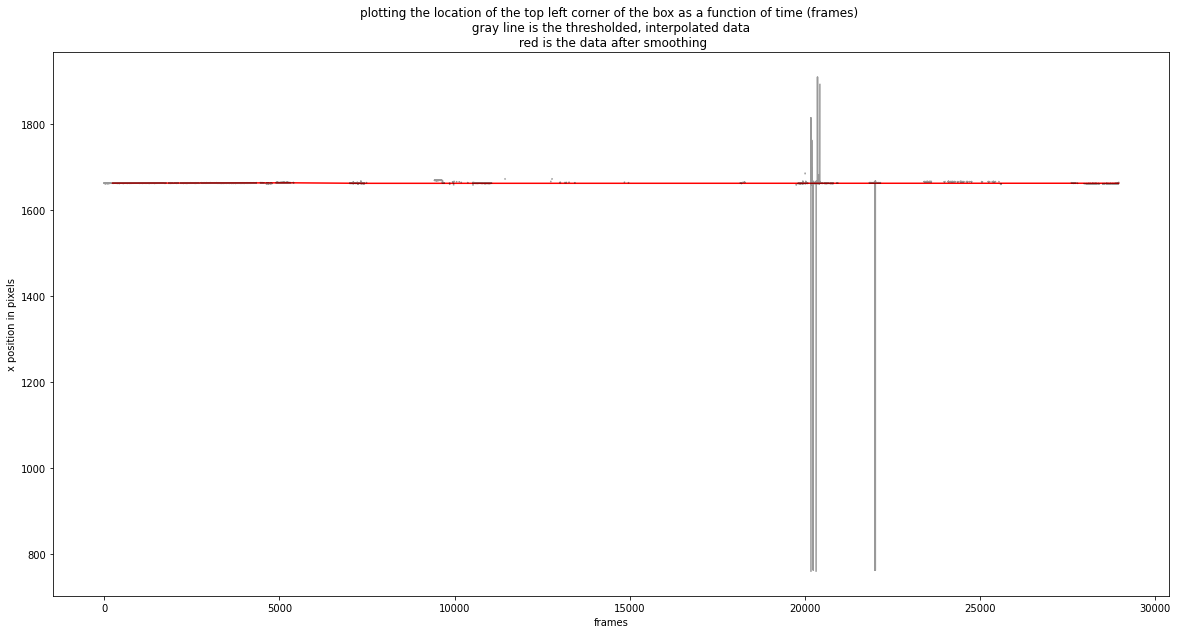

In [12]:
plt.figure(figsize=(20,10))
plt.plot(s.rolling(4*20).median().interpolate(),c='r')
plt.plot(s,c='k',alpha=0.4)
plt.title('plotting the location of the top left corner of the box as a function of time (frames) \n gray line is the thresholded, interpolated data \n red is the data after smoothing')
plt.xlabel('frames')
plt.ylabel('x position in pixels')
plt.show()

the above plot shows us that the camera field of view 'slides' about 70 pixels within the first 3000 frames, and then jitters a bit. These jitters are usually when the camera re-focuses, and deviations are quite small (< 10 pixels in a 1080x1920 pixel image)

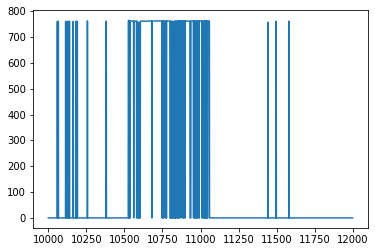

In [171]:
plt.plot(tst.y*list(tst.likelihood>0.72))



In [164]:
list(tst.likelihood>0.6)

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 T

col="box_tl"
likelihood_val=.6
max_px_value=200
part = df[col].copy()

for idx in np.arange(0,len(part.x)):
                if part.likelihood[idx] < likelihood_val:
                    part.x[idx] = np.nan
                    part.y[idx] = np.nan
                second_idx = np.max([0,idx-1])
                if abs(part.y[idx]-part.y[second_idx]) > max_px_value:
                    part[idx] = np.nan
                elif abs(part.x[idx]-part.x[second_idx]) > max_px_value:
                    part.x[idx] = np.nan
                    
part.x=part.x.rolling(seconds*fps).median()
part.x = part.x.interpolate()

part.y = part.y.interpolate()
part.y=part.y.rolling(seconds*fps).median()
print(seconds, fps, max_px_value)


In [13]:
# now that we have some idea of what values to use, let's apply this to the whole data frame 
# using our function reformat_df()
# this can take some time, but you should see printed statements regularly. 
new_df=reformat_df(df,0.72,1000,30,4,20)

bodyparts
box_bl


/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan
/tmp/ipykernel_3750960/2550143114.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y[idx] = np.nan
/tmp/ipykernel_3750960/2550143114.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x=part.x.rolling(seconds*fps).median()
/tmp/ipykernel_3750960/2550143114.p

box_br


/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan
/tmp/ipykernel_3750960/2550143114.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y[idx] = np.nan
/tmp/ipykernel_3750960/2550143114.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x=part.x.rolling(seconds*fps).median()
/tmp/ipykernel_3750960/2550143114.p

box_tl


/tmp/ipykernel_3750960/2550143114.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x=part.x.rolling(seconds*fps).median()
/tmp/ipykernel_3750960/2550143114.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate()
/tmp/ipykernel_3750960/2550143114.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

box_tr


/tmp/ipykernel_3750960/2550143114.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x=part.x.rolling(seconds*fps).median()
/tmp/ipykernel_3750960/2550143114.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate()
/tmp/ipykernel_3750960/2550143114.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

ear_left
ear_left
ear_right


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

ear_right
nose


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

nose
opening_bottom


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

opening_top


/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x[idx] = np.nan
/tmp/ipykernel_3750960/2550143114.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y[idx] = np.nan
/tmp/ipykernel_3750960/2550143114.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x=part.x.rolling(seconds*fps).median()
/tmp/ipykernel_3750960/2550143114.p

paw_left_back
paw_left_back
paw_left_front


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

paw_left_front
paw_right_back


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

paw_right_back
paw_right_front


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

paw_right_front
tail_base


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

tail_base
tail_tip


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

tail_tip


/tmp/ipykernel_3750960/2550143114.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.x = part.x.interpolate(limit=frame_limit_val)
/tmp/ipykernel_3750960/2550143114.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part.y = part.y.interpolate(limit=frame_limit_val)


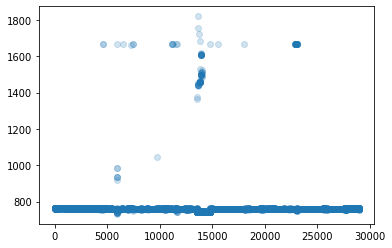

In [14]:
plt.scatter(df.box_tl.index,df.box_tl['y'],alpha=0.2)

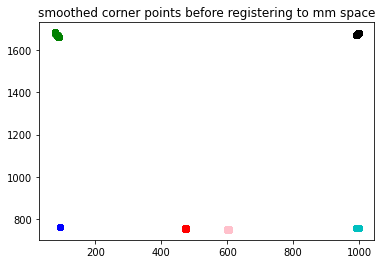

In [16]:
# let's see what this looks like: 
plt.scatter(new_df.box_bl['x'],new_df.box_bl['y'],c='g') #0,500mm
plt.scatter(new_df.box_br['x'],new_df.box_br['y'],c='k') #500,500mm
plt.scatter(new_df.box_tl['x'],new_df.box_tl['y'],c='b') #0,0mm`
plt.scatter(new_df.box_tr['x'],new_df.box_tr['y'],c='c') #500,0mm

plt.scatter(new_df.opening_bottom['x'],new_df.opening_bottom['y'],c='r')
plt.scatter(new_df.opening_top['x'],new_df.opening_top['y'],c='pink')
plt.title('smoothed corner points before registering to mm space')
plt.show()

# STOP! Wait to make sure the above plot looks good before moving on

In [17]:
# save this file
new_df.to_csv(filename[:-4]+"_adj.csv")

In [18]:
# load this file (this can be skipped, but if you already have an adjusted file and
# want to start from here you can do that)
new_df = pd.read_csv(filename[:-4]+"_adj.csv",header=[0,1],index_col=0)
new_df

box_bl                              box_br                          \
               x            y likelihood           x            y likelihood   
0            NaN          NaN   0.917342         NaN          NaN   0.992894   
1            NaN          NaN   0.917190         NaN          NaN   0.992912   
2            NaN          NaN   0.935872         NaN          NaN   0.987452   
3            NaN          NaN   0.949122         NaN          NaN   0.988341   
4            NaN          NaN   0.958582         NaN          NaN   0.986740   
...          ...          ...        ...         ...          ...        ...   
28955  88.705795  1660.391724   0.958823  992.501709  1669.930420   0.991186   
28956  88.691177  1660.408569   0.952378  992.506104  1669.937805   0.991293   
28957  88.684460  1660.424255   0.948562  992.508606  1669.942444   0.990708   
28958  88.682178  1660.431458   0.970451  992.519257  1669.946838   0.990731   
28959  88.677612  1660.434753   0.943505  992.533234  1669.950012   0.986030   

          box_tl                             box_tr  ... paw_right_back  \
               x           y likelihood           x  ...     likelihood   
0            NaN         NaN   0.739556         NaN  ...       0.037682   
1            NaN         NaN   0.724415         NaN  ...       0.037179   
2            NaN         NaN   0.718300         NaN  ...       0.040701   
3            NaN         NaN   0.721888         NaN  ...       0.041995   
4            NaN         NaN   0.615689         NaN  ...       0.052698   
...          ...         ...        ...         ...  ...            ...   
28955  92.290199  761.879822   0.842185  991.155487  ...       0.067631   
28956  92.290199  761.879822   0.830615  991.155487  ...       0.054701   
28957  92.290199  761.879822   0.693517  991.155487  ...       0.074272   
28958  92.290199  761.879822   0.661655  991.155487  ...       0.075398   
28959  92.290199  761.879822   0.814107  991.155487  ...       0.077986   

      paw_right_front                tail_base                tail_tip      \
                    x   y likelihood         x   y likelihood        x   y   
0                 NaN NaN   0.035374       NaN NaN   0.051596      NaN NaN   
1                 NaN NaN   0.035114       NaN NaN   0.051483      NaN NaN   
2                 NaN NaN   0.037399       NaN NaN   0.063882      NaN NaN   
3                 NaN NaN   0.037762       NaN NaN   0.069726      NaN NaN   
4                 NaN NaN   0.041372       NaN NaN   0.063823      NaN NaN   
...               ...  ..        ...       ...  ..        ...      ...  ..   
28955             NaN NaN   0.054711       NaN NaN   0.039256      NaN NaN   
28956             NaN NaN   0.049113       NaN NaN   0.037831      NaN NaN   
28957             NaN NaN   0.058031       NaN NaN   0.040745      NaN NaN   
28958             NaN NaN   0.056786       NaN NaN   0.037370      NaN NaN   
28959             NaN NaN   0.072319       NaN NaN   0.037326      NaN NaN   

                  
      likelihood  
0       0.168325  
1       0.163598  
2       0.216100  
3       0.196947  
4       0.267141  
...          ...  
28955   0.116662  
28956   0.156582  
28957   0.158470  
28958   0.212526  
28959   0.161556  

[28960 rows x 45 columns]

In [19]:
# next we're going to align these points to real coordinates
# we run the function aligned_df, which uses the DLC-labeled corners from each row
# and adjusts it and all other points in that line such that the corners of the box are at 0,0 0,500 500,0 and 500,500
aligned_df=align_df(new_df)
# save this dataframe 
aligned_df.to_csv(filename[:-4]+"_aligned.csv")

at 0 of 28960 rows
at 1000 of 28960 rows
at 2000 of 28960 rows
at 3000 of 28960 rows
at 4000 of 28960 rows
at 5000 of 28960 rows
at 6000 of 28960 rows
at 7000 of 28960 rows
at 8000 of 28960 rows
at 9000 of 28960 rows
at 10000 of 28960 rows
at 11000 of 28960 rows
at 12000 of 28960 rows
at 13000 of 28960 rows
at 14000 of 28960 rows
at 15000 of 28960 rows
at 16000 of 28960 rows
at 17000 of 28960 rows
at 18000 of 28960 rows
at 19000 of 28960 rows
at 20000 of 28960 rows
at 21000 of 28960 rows
at 22000 of 28960 rows
at 23000 of 28960 rows
at 24000 of 28960 rows
at 25000 of 28960 rows
at 26000 of 28960 rows
at 27000 of 28960 rows
at 28000 of 28960 rows


In [20]:
# load this file (this can be skipped, but if you already have an aligned file and want to start
# from here, you can do that)
aligned_df=pd.read_csv(filename[:-4]+"_aligned.csv",index_col=0,header=[0,1])

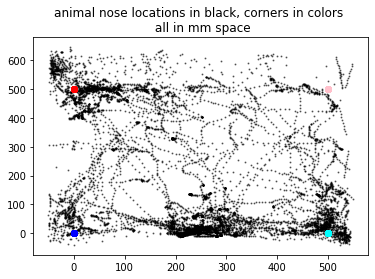

In [21]:
# next, let's see what our data look like now that it's in mm space
plt.scatter(aligned_df.nose['x'],aligned_df.nose['y'],c='k',s=1,alpha=0.5)
plt.scatter(aligned_df.box_bl['x'],aligned_df.box_bl['y'],c='r')
plt.scatter(aligned_df.box_br['x'],aligned_df.box_br['y'],c='pink')
plt.scatter(aligned_df.box_tl['x'],aligned_df.box_tl['y'],c='b')
plt.scatter(aligned_df.box_tr['x'],aligned_df.box_tr['y'],c='cyan')
plt.title('animal nose locations in black, corners in colors \n all in mm space')
plt.show()

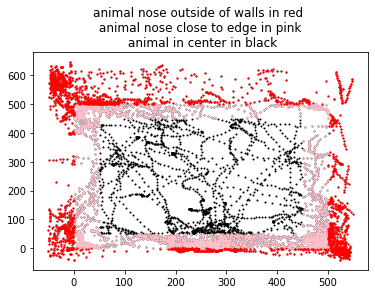

In [22]:
# let's look at the data again, but look to see when the animal is in the center of the box, close to the sides, or outside the box
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,s=1,c='k')
plt.scatter(aligned_df.nose.x[aligned_df.nose.x<50],aligned_df.nose.y[aligned_df.nose.x<50],c='pink',s=1)

plt.scatter(aligned_df.nose.x[aligned_df.nose.x>450],aligned_df.nose.y[aligned_df.nose.x>450],c='pink',s=1)

plt.scatter(aligned_df.nose.x[aligned_df.nose.y<50],aligned_df.nose.y[aligned_df.nose.y<50],c='pink',s=1)
plt.scatter(aligned_df.nose.x[aligned_df.nose.y>450],aligned_df.nose.y[aligned_df.nose.y>450],c='pink',s=1)

plt.scatter(aligned_df.nose.x[aligned_df.nose.x<0],aligned_df.nose.y[aligned_df.nose.x<0],c='r',s=1)
plt.scatter(aligned_df.nose.x[aligned_df.nose.x>500],aligned_df.nose.y[aligned_df.nose.x>500],c='r',s=1)
plt.scatter(aligned_df.nose.x[aligned_df.nose.y<0],aligned_df.nose.y[aligned_df.nose.y<0],c='r',s=1)
plt.scatter(aligned_df.nose.x[aligned_df.nose.y>500],aligned_df.nose.y[aligned_df.nose.y>500],c='r',s=1)
#plt.xlim([-100,600])
#plt.ylim([-100,600])
plt.title('animal nose outside of walls in red \n animal nose close to edge in pink \n animal in center in black')
plt.show()

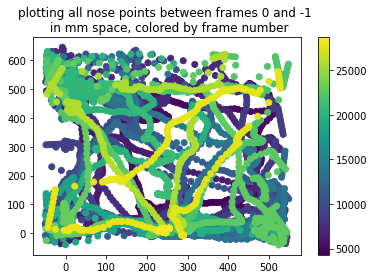

In [23]:
a=0
b=-1
plt.scatter(aligned_df.nose.x[a:b],aligned_df.nose.y[a:b],c=aligned_df.index[a:b])
plt.title('plotting all nose points between frames {} and {} \n in mm space, colored by frame number'.format(a,b))
plt.colorbar()
plt.show()

In [26]:
# a single point was found, around 1294 frames in,
# then the rolling median filled in some additional points
# let's look at the actual data
aligned_df.nose[1290:1320]

,x,y,likelihood
1290,NaN,NaN,0.200321
1291,NaN,NaN,0.190151
1292,NaN,NaN,0.198159
1293,NaN,NaN,0.199489
1294,NaN,NaN,0.194107
1295,NaN,NaN,0.195620
1296,NaN,NaN,0.197847
1297,NaN,NaN,0.196891
1298,NaN,NaN,0.195294
1299,NaN,NaN,0.195944


In [27]:
# this is early on in the video, and could be the first labeled nose point
# if so, adding up all of the nose's x positions will give us a 0
print(np.sum(aligned_df.nose.x[0:1290]))

0.0


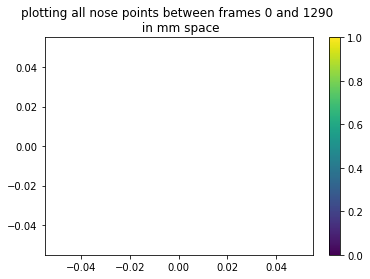

In [28]:
a=0
b=1290
# and plotting before 1290 should show no points
plt.title('plotting all nose points between frames {} and {} \n in mm space'.format(a,b))
plt.scatter(aligned_df.nose.x[a:b],aligned_df.nose.y[a:b],c='k')
plt.colorbar()
plt.show()

/tmp/ipykernel_3750960/3334595084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aligned_df.nose.x[0:1390]=np.nan
/tmp/ipykernel_3750960/3334595084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aligned_df.nose.y[0:1390]=np.nan


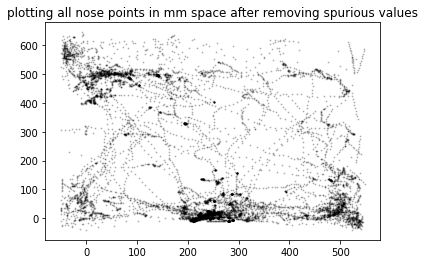

In [29]:
# so we can remove this point and re-run our align script, or just remove these nose points entirely
# I'm going to go with the latter
aligned_df.nose.x[0:1390]=np.nan
aligned_df.nose.y[0:1390]=np.nan
a=0
b=-1
plt.scatter(aligned_df.nose.x[a:b],aligned_df.nose.y[a:b],c='k',alpha=0.2,s=1)
plt.title('plotting all nose points in mm space after removing spurious values')
plt.show()

In [30]:
# let's save over the file now that we've corrected these values
aligned_df.to_csv(filename[:-4]+"_aligned.csv")

In [31]:
frames_with_nose=[]
frames_with_head=[]
frames_with_body=[]
l_frames=[]
frames_within_50mm=[]
fraction_frames_within_50mm=[]
fraction_LIGHT_frames_within_50mm=[]
fraction_LIGHT_frames_in_center=[]
first_frame_in_center=[]
num_entrances=[]
total_frames=[]
num_jumps=[]
num_rears=[]
num_frames_jumping=[]
num_frames_rearing=[]
first_nose_in_box=[]
first_head_in_box=[]
first_body_in_box=[]
sum_dist=[]
sum_dist_without_jumps=[]

# let's generate some summary data
nose_vals = ~np.isnan(aligned_df.nose['x'])
ear_l_vals = ~np.isnan(aligned_df.ear_left['x'])
ear_r_vals = ~np.isnan(aligned_df.ear_right['x'])
tail_vals = ~np.isnan(aligned_df.tail_base['x'])

# make a subset of just the location (x,y) and prediction value
#(likelihood) of the animal's nose
nose_df=aligned_df.nose
nose_df['within50mm']=0
for idx in nose_df.index:
                xval=nose_df.x[idx]
                yval=nose_df.y[idx]
                if xval < 50 or xval > 450 or yval < 50 or yval > 450:
                    nose_df.iloc[idx,3]=1 #3 is the column we're filling with ones
                    #if and only if the points are outside the box

            # get some summary data: # of frames with the nose in?
            # nose + ears (aka head)? nose + ears + tailbase? (aka body)
            # I chose these points because the paws and tail tip aren't always
            # picked up as well by DLC, so these are high-fidelity pts
frames_with_nose.append(np.sum(nose_vals))
# if the nose entered the box, find the first entrance frame, else: nan
if frames_with_nose[-1]>0:
                first_nose_in_box.append(np.argmax(nose_vals))
else:
                first_nose_in_box.append(np.argmax(nose_vals))
frames_with_head.append(np.sum(nose_vals*ear_l_vals*ear_r_vals))
# if the HEAD entered the box, find the first entrance frame, else: nan
if frames_with_head[-1]>0:
                first_head_in_box.append(np.argmax(nose_vals*ear_l_vals*ear_r_vals))
else:
                first_head_in_box.append(np.nan)
# if the BODY entered the box, find the first entrance frame, else: nan
frames_with_body.append(np.sum(nose_vals*ear_l_vals*ear_r_vals*tail_vals))
if frames_with_body[-1]>0:
                first_body_in_box.append(np.argmax(nose_vals*ear_l_vals*ear_r_vals*tail_vals))
else:
                first_body_in_box.append(np.nan)
total_frames.append(len(nose_vals))

# let's generate some more summary data:
nose_sum=np.sum(nose_vals)
summed_val=np.sum(nose_df.within50mm)
# how many frames are within 50mm of the edges of the box? (inluding
# those outside the edges which are jumps or rears)
frames_within_50mm.append(summed_val)
fraction_frames_within_50mm.append(summed_val/len(nose_df))
fraction_LIGHT_frames_in_center.append((nose_sum-summed_val)/nose_sum)
fraction_LIGHT_frames_within_50mm.append(summed_val/nose_sum)
sub_nose_df=nose_df[~np.isnan(nose_df.x)]
sub_nose_df=sub_nose_df[sub_nose_df.within50mm<1]
try:
                first_frame_in_center.append(sub_nose_df.index[0])
except:
                first_frame_in_center.append(np.nan)
# add 2 cols to df: one for if the animal was in box or not, and one for
#the "bout number" which gives us # of entrances
# also keep track of inter-bout-intervals
aligned_df['in_box']=float(0)
aligned_df['light_bout_num']=float(0)
inter_light_interval=np.zeros(len(aligned_df))
inter_light_bout=0
bout_num=0
for idx in aligned_df.index:
                if np.isnan(aligned_df.nose.x[idx]):
                    aligned_df.iloc[idx,-2]=0
                    aligned_df.iloc[idx,-1]=0
                    if aligned_df.iloc[idx-1,-2]>0:
                        inter_light_bout+=1
                    inter_light_interval[idx]=inter_light_bout
                elif aligned_df.iloc[idx-1,-2]==0:
                    bout_num+=1
                    aligned_df.iloc[idx,-2]=1
                    aligned_df.iloc[idx,-1]=bout_num
                else:
                    aligned_df.iloc[idx,-2]=1
                    aligned_df.iloc[idx,-1]=bout_num
num_entrances.append(np.max(aligned_df.light_bout_num))


/tmp/ipykernel_3750960/1005842811.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nose_df['within50mm']=0


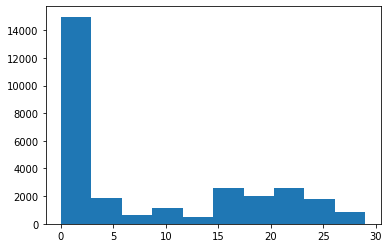

In [32]:
# plot inter light bout histogram
plt.hist(inter_light_interval)#
#plt.savefig(os.path.join('..','data','results',sub_file_name+"_inter_light_bout_hist.png"))
plt.show()

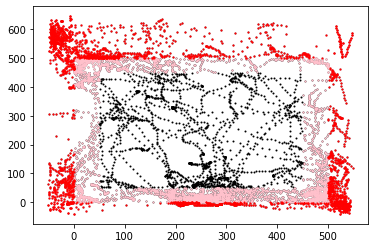

In [33]:
plt.scatter(nose_df.x,nose_df.y,s=1,c='k')
plt.scatter(nose_df.x[nose_df.x<50],nose_df.y[nose_df.x<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.x>450],nose_df.y[nose_df.x>450],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y<50],nose_df.y[nose_df.y<50],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.y>450],nose_df.y[nose_df.y>450],c='pink',s=1)
plt.scatter(nose_df.x[nose_df.x<0],nose_df.y[nose_df.x<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.x>500],nose_df.y[nose_df.x>500],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y<0],nose_df.y[nose_df.y<0],c='r',s=1)
plt.scatter(nose_df.x[nose_df.y>500],nose_df.y[nose_df.y>500],c='r',s=1)            
#plt.savefig(os.path.join('..','data','results',sub_file_name+"_all-points_color_within50mm.png"))


In [34]:
# get distances between animal's body points THIS CAN TAKE A WHILE (minutes on a laptop)

aligned_df['dists','nose_midpoint_entrance']=float(0)
aligned_df['dists','nose_ear_right']=float(0)
aligned_df['dists','nose_ear_left']=float(0)
aligned_df['dists','nose_paw_left_back']=float(0)
aligned_df['dists','nose_paw_left_front']=float(0)
aligned_df['dists','nose_paw_right_back']=float(0)
aligned_df['dists','nose_paw_right_front']=float(0)
aligned_df['dists','nose_tail_tip']=float(0)
aligned_df['dists','nose_tail_base']=float(0)
aligned_df['speed']=float(0)
nanmean_xs=np.zeros(len(aligned_df))
nanmean_ys=np.zeros(len(aligned_df))
animal_dist_traveled=np.zeros(len(aligned_df))
entrance_x=np.nanmean([np.nanmedian(aligned_df.opening_top.x),np.nanmedian(aligned_df.opening_bottom.x[idx])])
entrance_y=np.nanmean([np.nanmedian(aligned_df.opening_top.y),np.nanmedian(aligned_df.opening_bottom.y[idx])])
ind_idx=-1
for idx in aligned_df.index:
                ind_idx+=1
                rel_idx = idx-aligned_df.index[0]
                nanmean_xs[ind_idx]=np.nanmean(
                        [aligned_df.nose.x[idx],
                        aligned_df.ear_left.x[idx],
                        aligned_df.ear_right.x[idx],
                        aligned_df.tail_base.x[idx]])
                nanmean_ys[ind_idx]=np.nanmean(
                        [aligned_df.nose.y[idx],
                        aligned_df.ear_left.y[idx],
                        aligned_df.ear_right.y[idx],
                        aligned_df.tail_base.y[idx]])
                if rel_idx > 0:
                    speed = np.abs(math.dist([nanmean_xs[ind_idx],nanmean_ys[ind_idx]],[nanmean_xs[ind_idx-1],nanmean_ys[ind_idx-1]]))
                else:
                    speed=0
                animal_dist_traveled[ind_idx]=speed
                aligned_df.iloc[rel_idx,-1]=speed
                aligned_df.iloc[rel_idx,-2]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_base.x[idx],aligned_df.tail_base.y[idx]])
                aligned_df.iloc[rel_idx,-3]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.tail_tip.x[idx],aligned_df.tail_tip.y[idx]])
                aligned_df.iloc[rel_idx,-4]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_front.x[idx],aligned_df.paw_right_front.y[idx]])
                aligned_df.iloc[rel_idx,-5]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_right_back.x[idx],aligned_df.paw_right_back.y[idx]])
                aligned_df.iloc[rel_idx,-6]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_front.x[idx],aligned_df.paw_left_front.y[idx]])
                aligned_df.iloc[rel_idx,-7]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.paw_left_back.x[idx],aligned_df.paw_left_back.y[idx]])
                aligned_df.iloc[rel_idx,-8]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_left.x[idx],aligned_df.ear_left.y[idx]])
                aligned_df.iloc[rel_idx,-9]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[aligned_df.ear_right.x[idx],aligned_df.ear_right.y[idx]])
                aligned_df.iloc[rel_idx,-10]=math.dist([aligned_df.nose.x[idx],aligned_df.nose.y[idx]],[entrance_x,entrance_y])
aligned_df['inter_light_bout']=inter_light_interval
aligned_df['nanmean_x']=nanmean_xs
aligned_df['nanmean_y']=nanmean_ys
aligned_df['animal_dist_traveled']=animal_dist_traveled
#aligned_df.to_csv(os.path.join('..','data','results',sub_file_name+"_aligned_dists.csv"))

/tmp/ipykernel_3750960/2731833171.py:22: RuntimeWarning: Mean of empty slice
  nanmean_xs[ind_idx]=np.nanmean(
/tmp/ipykernel_3750960/2731833171.py:27: RuntimeWarning: Mean of empty slice
  nanmean_ys[ind_idx]=np.nanmean(


In [35]:
aligned_df.to_csv(os.path.join('..','data','results',sub_file_name+"_aligned_dists.csv"))

In [36]:
# load aligned_dists file if you want to start notebook from here 
#aligned_df = pd.read_csv(os.path.join('..','data','results',sub_file_name+"_aligned_dists.csv"),header=[0,1])

In [37]:
df_for_prediction=pd.concat([aligned_df['nose']['x'],aligned_df['nose','y'],aligned_df['nose']['likelihood'],aligned_df['tail_base']['likelihood'],aligned_df['paw_left_back']['likelihood'],aligned_df['paw_right_back']['likelihood'],aligned_df['dists']['nose_midpoint_entrance'],aligned_df['dists']['nose_tail_base'],aligned_df['speed']],axis=1)
df_for_prediction.columns=['nose_x','nose_y','nose_likelihood','tail_base_likelihood','paw_lb_likelihood','paw_rb_likelihood','dists_fromentrance','dists_nose_tail_base','speed']
try:
                cols=aligned_df.animal_dist_traveled.columns[0]
                animal_dist_traveled=aligned_df.animal_dist_traveled[cols]
except:
                animal_dist_traveled=aligned_df['animal_dist_traveled']

In [38]:
# load classifier, trained_file is a variable defined in User Inputs
clf = joblib.load(trained_file)
preds_to_plot=clf.predict(df_for_prediction.fillna(0))

/home/dennislab2/anaconda3/envs/fieldwork_2021/lib/python3.10/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dennislab2/anaconda3/envs/fieldwork_2021/lib/python3.10/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s

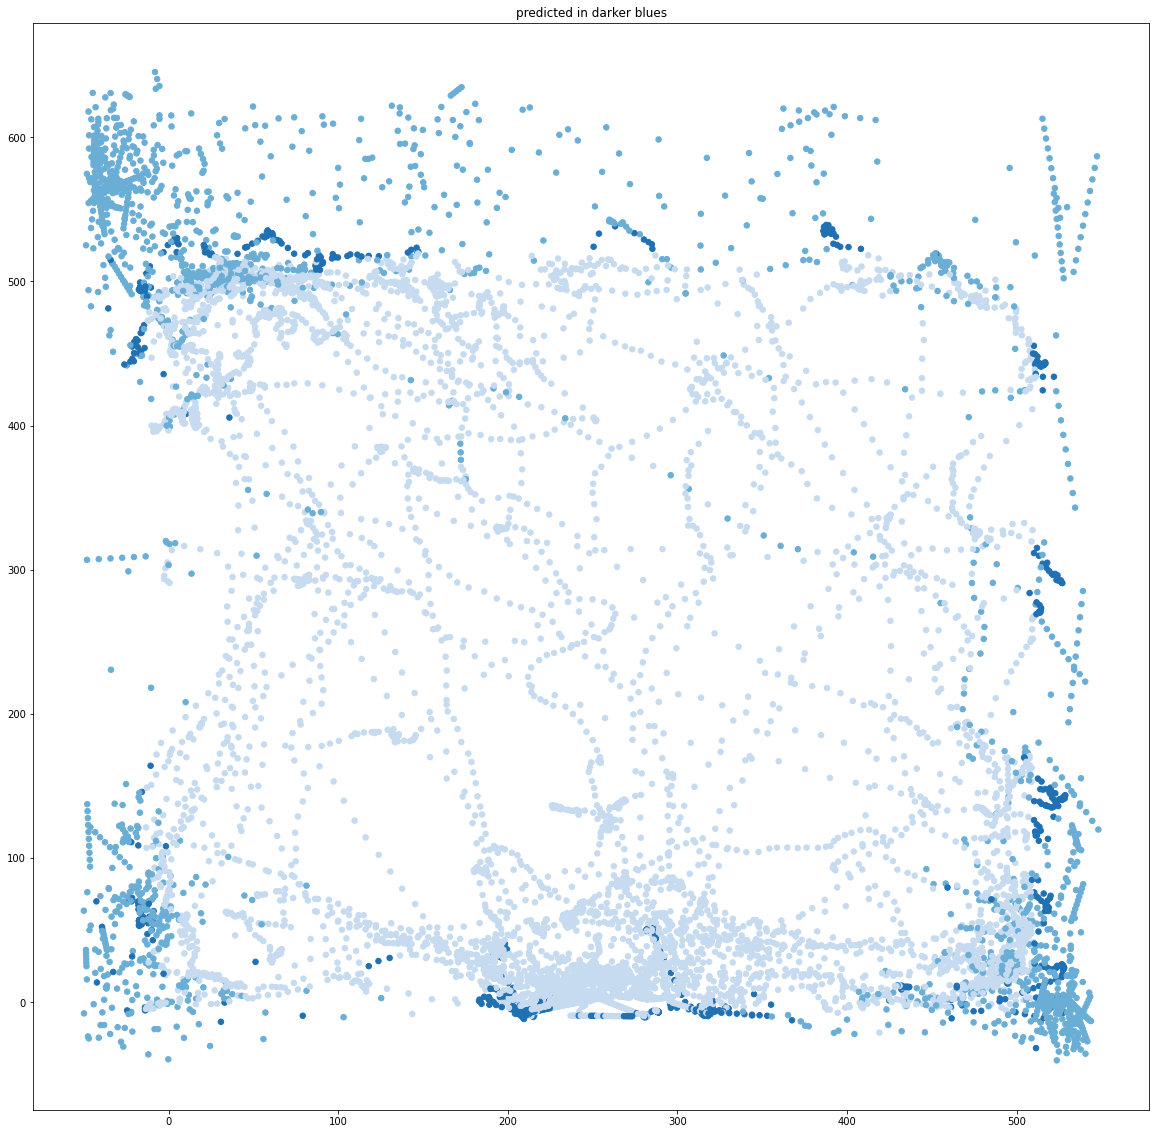

In [39]:
plt.figure(figsize=(20,20))
plt.scatter(aligned_df.nose.x,aligned_df.nose.y,c=preds_to_plot,cmap="Blues",s=30)
plt.clim([-1,3])
plt.title('predicted in darker blues')
#plt.savefig(os.path.join('..','data','results',sub_file_name+'_predicted_jumps.png'))
plt.show()

In [40]:
# now let's get some summary data based on the predictions 
jump_bouts = np.zeros(len(preds_to_plot))
jump_bout_num=0
rear_bouts = np.zeros(len(preds_to_plot))
rear_bout_num=0

for idx in np.arange(4,len(preds_to_plot)):
                if preds_to_plot[idx]==1:
                    if 1 not in np.unique(preds_to_plot[idx-4:idx]):
                        jump_bout_num+=1
                    jump_bouts[idx]=jump_bout_num
                elif preds_to_plot[idx]==2:
                    if 2 not in np.unique(preds_to_plot[idx-4:idx]):
                        rear_bout_num+=1
                    rear_bouts[idx]=rear_bout_num

# now remove jumps that don't have at least 4 frames
# and get inter-jump-bouts
vals_to_rm=[]
rear_vals_to_rm=[]
animal_dist_traveled_without_jumps=np.abs(animal_dist_traveled.copy())
jump_bouts_list=list(jump_bouts)
rear_bouts_list=list(rear_bouts)
inter_jump_bout_num=0
inter_jump_bouts=np.zeros(len(preds_to_plot))
for val in np.unique(rear_bouts):
                if rear_bouts_list.count(val) < 4:
                    rear_vals_to_rm.append(val)
for idx in np.arange(0,len(rear_bouts)):
                if rear_bouts[idx] in rear_vals_to_rm:
                    rear_bouts[idx]=0

for val in np.unique(jump_bouts):
                if jump_bouts_list.count(val) < 4:
                    vals_to_rm.append(val)
for idx in np.arange(0,len(jump_bouts)):
                if jump_bouts[idx] in vals_to_rm:
                    jump_bouts[idx]=0
                    animal_dist_traveled_without_jumps[idx]=0
                if idx < len(jump_bouts)-1 and jump_bouts[idx]>0:
                    if jump_bouts[idx+1]==0:
                        inter_jump_bout_num+=1
                    else:
                        inter_jump_bouts[idx]=inter_jump_bout_num

# get the number of unique 4+ length jumps
num_jumps.append(len(np.unique(jump_bouts)))
num_rears.append(len(np.unique(rear_bouts)))
num_frames_jumping.append(len(jump_bouts[jump_bouts>0]))
num_frames_rearing.append(len(rear_bouts[rear_bouts>0]))
prediction = aligned_df.copy()
prediction['predicted_jumps']=preds_to_plot
prediction['jump_bouts']=jump_bouts
prediction['rear_bouts']=rear_bouts

# get distance traveled under different jump inclusion/exclusions
prediction['inter_jump_bouts']=inter_jump_bouts

#save out prediction csv
prediction['animal_dist_without_jumps']=animal_dist_traveled_without_jumps
sum_dist_without_jumps.append(np.sum(animal_dist_traveled_without_jumps))
sum_dist.append(np.sum(np.abs(animal_dist_traveled)))
prediction.to_csv(os.path.join('..','data','results',sub_file_name+"_predictions.csv"))

# classifier info

In [41]:
# we used manual annotations and combined them with DLC predictions into one dataframe for many videos 
all_anns=pd.read_csv('../data/provided_data/all_anns.csv',header=[0,1],index_col=0)
all_anns

box_bl                   box_br                          box_tl  \
                   x      y likelihood      x      y likelihood             x   
0       1.426239e-14  500.0   0.955064  500.0  500.0   0.994366  1.422065e-14   
1       1.426229e-14  500.0   0.955014  500.0  500.0   0.996492  1.422057e-14   
2       1.426188e-14  500.0   0.954693  500.0  500.0   0.995657  1.422048e-14   
3      -1.426178e-14  500.0   0.957330  500.0  500.0   0.995790 -1.422050e-14   
4       1.426229e-14  500.0   0.956928  500.0  500.0   0.996209  2.844132e-14   
...              ...    ...        ...    ...    ...        ...           ...   
107737 -3.677647e-15  500.0   0.978973  500.0  500.0   0.835657 -1.080077e-14   
107738 -3.677641e-15  500.0   0.969021  500.0  500.0   0.836974 -7.200504e-15   
107739 -7.355266e-15  500.0   0.977024  500.0  500.0   0.834068 -7.200496e-15   
107740  7.355242e-15  500.0   0.968560  500.0  500.0   0.837446 -3.600241e-15   
107741  0.000000e+00  500.0   0.971802  500.0  500.0   0.838634  0.000000e+00   

                                box_tr  ...               dists  \
                   y likelihood      x  ... nose_paw_right_back   
0       0.000000e+00   0.986164  500.0  ...                 NaN   
1      -2.844114e-14   0.988763  500.0  ...                 NaN   
2       0.000000e+00   0.989446  500.0  ...                 NaN   
3      -2.844100e-14   0.987699  500.0  ...                 NaN   
4       8.532397e-14   0.986610  500.0  ...                 NaN   
...              ...        ...    ...  ...                 ...   
107737  0.000000e+00   0.925364  500.0  ...                 NaN   
107738  0.000000e+00   0.929383  500.0  ...                 NaN   
107739  5.760397e-14   0.938096  500.0  ...                 NaN   
107740  5.760386e-14   0.936909  500.0  ...                 NaN   
107741 -5.760357e-14   0.933958  500.0  ...                 NaN   

                                                                       speed  \
       nose_paw_right_front nose_tail_tip nose_tail_base Unnamed: 58_level_1   
0                       NaN           NaN            NaN            0.000000   
1                       NaN           NaN            NaN                 NaN   
2                       NaN           NaN            NaN                 NaN   
3                       NaN           NaN            NaN                 NaN   
4                       NaN           NaN            NaN                 NaN   
...                     ...           ...            ...                 ...   
107737                  NaN     65.581758      58.906834            6.013771   
107738                  NaN     64.557644      57.424632            2.257467   
107739                  NaN     63.522430      59.607540            3.011795   
107740                  NaN     60.521468      62.279788            5.710309   
107741                  NaN     57.573913      64.186850            4.593553   

          inter_light_bout           nanmean_x           nanmean_y  \
       Unnamed: 59_level_1 Unnamed: 60_level_1 Unnamed: 61_level_1   
0                      0.0                 NaN                 NaN   
1                      0.0                 NaN                 NaN   
2                      0.0                 NaN                 NaN   
3                      0.0                 NaN                 NaN   
4                      0.0                 NaN                 NaN   
...                    ...                 ...                 ...   
107737                 0.0          112.702097          375.753510   
107738                 0.0          112.965813          376.151154   
107739                 0.0          112.230855          377.071649   
107740                 0.0          111.197896          378.097064   
107741                 0.0          110.714238          379.343396   

       animal_dist_traveled                anns  
        Unnamed: 62_level_1 Unnamed: 63_level_1  
0                  0.000000         

In [42]:
df_for_training=pd.concat([all_anns['nose']['x'],all_anns['nose','y'],all_anns['nose']['likelihood'],all_anns['tail_base']['likelihood'],all_anns['paw_left_back']['likelihood'],all_anns['paw_right_back']['likelihood'],all_anns.dists.nose_midpoint_entrance,all_anns.dists['nose_tail_base'],all_anns.speed['Unnamed: 58_level_1']],axis=1)
df_for_training.columns=['nose_x','nose_y','nose_likelihood','tail_base_likelihood','paw_lb_ikelihood','paw_rb_likelihood','dists_fromentrance','dists_nose_tail_base','speed']
df_for_training_annots=all_anns.anns['Unnamed: 63_level_1']
xVar=df_for_training.columns
yVar=df_for_training_annots
df_for_training=df_for_training.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(df_for_training, yVar, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(86193, 9) (86193,)
(21549, 9) (21549,)


""" we used the below code to create the Random Forest Classifier used currently, **change this cell
from Markdown to Code block and run to re-create** (it will not be identical! but will be close) """

clf = RandomForestClassifier(bootstrap=False, 
            class_weight=None, 
            criterion='gini',
            max_depth=None, 
            max_features='auto', 
            max_leaf_nodes=None,
            min_samples_leaf=1,
            min_samples_split=2, 
            min_weight_fraction_leaf=0.0,
            n_estimators=100, 
            n_jobs=4, 
            oob_score=False,
            random_state=0,
            verbose=1, 
            warm_start=False)


""" to save a new classifier change the name below """
joblib.dump(clf, '../data/yourclassifiernamehere.pkl') 

In [43]:
# determining how well the classifier works 
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
acc =  clf.score(X_test, y_test)
print(acc) #this is the accuracy of the model

print(list(zip(X_train, clf.feature_importances_)))
pd.crosstab(y_test, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


0.8960972666945102
[('nose_x', 0.08457010477204387), ('nose_y', 0.08533782094376256), ('nose_likelihood', 0.14160627626406955), ('tail_base_likelihood', 0.174080107786383), ('paw_lb_ikelihood', 0.14343488038971278), ('paw_rb_likelihood', 0.1444126763106756), ('dists_fromentrance', 0.09935081662175976), ('dists_nose_tail_base', 0.06658087028424639), ('speed', 0.060626446627346654)]


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Predicted Result,0.0,1.0,2.0
Actual Result,,,
0.0,17629,42,188
1.0,548,212,33
2.0,1426,2,1469


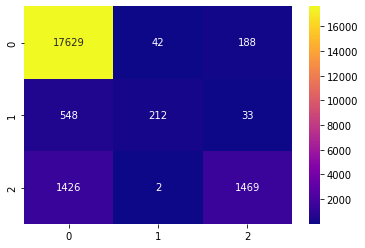

In [44]:
# here is one plot of the confusion matrix 
cm = pd.DataFrame(confusion_matrix(y_test, preds))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

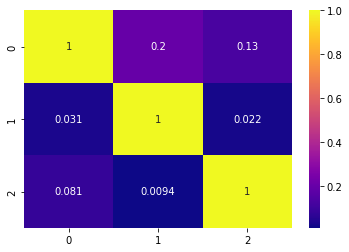

In [45]:
# here we scale the map by column and replot the confusion matrix
# this is helpful because there are more 0s than anything else
for col in cm.columns:
    cm[col]=np.divide(cm[col],np.max(cm[col]))

sns.heatmap(cm, annot=True,cmap='plasma');

ValueError: 'c' argument has 28960 elements, which is inconsistent with 'x' and 'y' with size 107742.

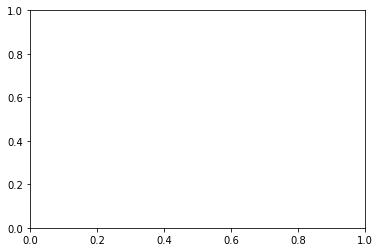

In [46]:
# here we plot all predictions
plt.scatter(all_anns.nose.x,all_anns.nose.y,c=preds_to_plot,cmap="Blues",s=5,alpha=.4)
plt.clim([0,2])
plt.title('predicted in darker blues')

In [ ]:
# here we plot all annotations
plt.scatter(all_anns.nose.x,all_anns.nose.y,c=yVar,cmap="Blues",s=5,alpha=.4)
plt.clim([0,2])
plt.title('annotated in darker blues')

In [ ]:
# here we plot all predicted jumps and annotated jumps
plt.scatter(all_anns.nose.x[preds_to_plot==1],all_anns.nose.y[preds_to_plot==1],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==1],all_anns.nose.y[yVar==1],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

In [ ]:
# here we plot all predicted rears and annotated rears
plt.scatter(all_anns.nose.x[preds_to_plot==2],all_anns.nose.y[preds_to_plot==2],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==2],all_anns.nose.y[yVar==2],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

In [ ]:
# we can list the features and their weights (higher = used more)
list(zip(X_train, clf.feature_importances_))

In [ ]:
# and can look at the decision trees 
decision_tree_num=0

plt.figure(figsize=(20,20))
_=tree.plot_tree(clf.estimators_[decision_tree_num])

In [ ]:
# to plot just part of a tree, try this:
plt.figure(figsize=(40,40))
max_depth=3
_ = tree.plot_tree(clf.estimators_[decision_tree_num], feature_names=X_train.columns,max_depth=max_depth,label='none',filled=True,impurity=False)
#plt.savefig('/Users/dennise/Desktop/DT_jumps_for_Alex_TOP{}.png'.format(max_depth))

## kmeans 

In [ ]:
# we can use the same general method to make a kmeans classifier
# first let's see how many neighbors are useful for our data
for n in [2,3,4,5,10,20,100]:
    classifier = KNeighborsClassifier(n_neighbors=n)
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_test)
    acc =  classifier.score(X_test, y_test)
    print(n,acc)
    # this shows that 3 is the best fit

In [ ]:
n=3
classifier = KNeighborsClassifier(n_neighbors=n)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc =  classifier.score(X_test, y_test)
print(acc)

#joblib.dump(classifier, '../data/20230216_Kmeans_jumpsrears.pkl') 
#clf = joblib.load('../data/20230216_Kmeans_jumpsrears.pkl')

In [ ]:
# and we can make the same confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True, fmt='d',cmap='plasma');

In [ ]:
# scaled confusion matrix 
for col in cm.columns:
    cm[col]=np.divide(cm[col],np.max(cm[col]))

sns.heatmap(cm, annot=True,cmap='plasma');

In [ ]:
# predictions 
preds_to_plot=classifier.predict(df_for_training.fillna(0))
plt.scatter(df_for_training.nose_x,df_for_training.nose_y,c=preds_to_plot,cmap="Blues",alpha=.1,s=5)
plt.clim([0,2])

In [ ]:
# annotations
preds_to_plot=classifier.predict(df_for_training.fillna(0))
plt.scatter(df_for_training.nose_x,df_for_training.nose_y,c=df_for_training_annots,cmap="Blues",alpha=.1,s=5)
plt.clim([0,2])

In [ ]:
# predicted vs annotated jumps
plt.scatter(all_anns.nose.x[preds_to_plot==1],all_anns.nose.y[preds_to_plot==1],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==1],all_anns.nose.y[yVar==1],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')

In [ ]:
# predicted vs annotated rears
plt.scatter(all_anns.nose.x[preds_to_plot==2],all_anns.nose.y[preds_to_plot==2],c='y',s=8)
plt.scatter(all_anns.nose.x[yVar==2],all_anns.nose.y[yVar==2],s=8,c='c',alpha=0.2)
plt.title('predicted in yellow, ground truth in cyan')